## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


### Reference
* https://blog.csdn.net/A_a_ron/article/details/79050204
* https://github.com/keras-team/keras/issues/369
* https://github.com/keras-team/keras/issues/3977

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\Win10\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

def focal_loss(y_true, y_pred,gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)
 
def cross_entropy(y_true, y_pred):         
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
            
    entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred)
    return tf.reduce_mean(entropy)

def combined_loss(W1=0.3,W2=0.7):    
    def combined_loss_fixed(y_true,y_pred):
        f_loss = focal_loss(y_true,y_pred)
        cr = cross_entropy(y_true,y_pred)
        conbin_loss = f_loss * W1 + cr * W2
        return conbin_loss
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss =combined_loss(W1=ce_w,W2=1-ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]
                            }

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

Epoch 11/25
50000/50000 [==============================] - 11s 214us/step - loss: 2.3490 - acc: 0.5789 - val_loss: 2.7032 - val_acc: 0.4718
Epoch 12/25
50000/50000 [==============================] - 11s 218us/step - loss: 2.3148 - acc: 0.5878 - val_loss: 2.6808 - val_acc: 0.4790
Epoch 13/25
50000/50000 [==============================] - 11s 221us/step - loss: 2.2799 - acc: 0.5995 - val_loss: 2.6771 - val_acc: 0.4791
Epoch 14/25
50000/50000 [==============================] - 11s 225us/step - loss: 2.2443 - acc: 0.6111 - val_loss: 2.6773 - val_acc: 0.4766
Epoch 15/25
50000/50000 [==============================] - 11s 225us/step - loss: 2.2116 - acc: 0.6209 - val_loss: 2.6695 - val_acc: 0.4798
Epoch 16/25
50000/50000 [==============================] - 11s 216us/step - loss: 2.1814 - acc: 0.6307 - val_loss: 2.6707 - val_acc: 0.4843
Epoch 17/25
50000/50000 [==============================] - 11s 215us/step - loss: 2.1492 - acc: 0.6410 - val_loss: 2.6868 - val_acc: 0.4738
Epoch 18/25
50000/50

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 241us/step - loss: 5.1170 - acc: 0.3124 - val_loss: 5.3581 - val_acc: 0.3197
Epoch 2/25
50000/50000 [==============================] - 11s 213us/step - loss: 3.8102 - acc: 0.4322 - val_loss: 4.2818 - val_acc: 0.3950
Epoch 3/25
50000/50000 [==============================] - 11s 214us/step - loss: 3.4900 - acc: 0.4741 - val_loss: 3.7764 - val_acc: 0.4313
Epoch 4/25
50000/50000 [==============================] - 11s 214us/step - loss: 3.2831 - acc: 0.5024 - val_loss: 3.6154 - val_acc: 0.4507
Epoch 5/25
50000/50000 [==============================] - 11s 211us/step - loss: 3.1274 - acc: 0.5240 - val_loss: 3.5208 - val_acc: 0.4621
Epoch 6/25
50000/50000 [==============================] - 11s 211us/step - loss: 2.9970 - acc: 0.5430 - val_loss: 3.5722 - val_acc: 0.4627
Epoch 7/25
50000/50000 [==============================] - 11s 210us/step - loss: 2.8749 - acc: 0.5620 - val_loss: 3.

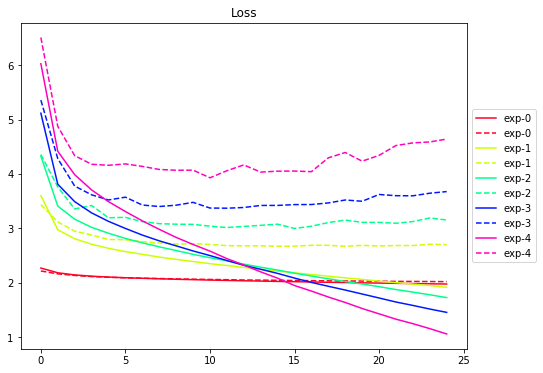

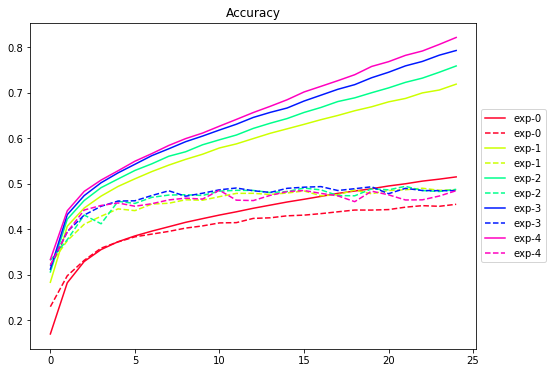

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()